## TSP Miller–Tucker–Zemlin (MTZ) Callbacks Formulation

##### Keywords:  TSP, MTZ, Miller–Tucker–Zemlin, Subtours, Linear Programming, Cplex, Python, Networkx, Docplex, Callback, LazyConstraintCallback  

$ \text{Variables} $

$x_{ij}={\begin{cases}1&{\text{the path goes from city }}i{\text{ to city }}j\\0&{\text{otherwise}}\end{cases}}$

$u_{i}=\text{keeps track of the order in which the cities are visited, counting from city 1 the interpretation is that $u_{i}$ < $u_{j}$ implies city i}\\ \quad ~~~~\text{is visited before city j}$

\begin{equation*}
\begin{aligned}
& \underset{}{\text{Minimize}}
& & \sum_{i=1}^{n} \sum_{j=1, j\neq i}^{n} c_{ij} x_{ij} \\
& \text{Subject to}
& & \sum_{j=1, j\neq i}^{n} x_{ij} = 1, \quad i = 1,\ldots,n, \\
& 
& & \sum_{i=1, i\neq j}^{n} x_{ij} = 1, \quad j = 1,\ldots,n, \\
& 
& & u_{i} - u_{j} + n x_{ij} \leq n - 1, \quad 2 \leq i \neq j \leq n.\\
&
& & x_{ij} \in \{0,1\}, \quad i,j = 1,\ldots,n, \, i\neq j, \\
&
& & u_{i} \in \mathbf {Z}, \quad i=2,\ldots ,n.
\end{aligned}
\end{equation*}


#### Import Library and Model Enviroment

In [1]:
from docplex.mp.model import Model
import networkx as nx   
import numpy as np
import matplotlib.pyplot as plt
mdl=Model('MTZ')

#### Function to Visualize the Traveling Salesman Problem (TSP) Graphically

In [2]:
def graphic(x, d, N):
    """
    Function to visualize the Traveling Salesman Problem (TSP) graphically.

    Parameters:
        x (numpy.ndarray): Distance matrix representing the pairwise distances between cities.
        d (list): List of cities with their corresponding distances.
        N (range): Range object representing the number of cities.

    Returns:
        None
    """

    edges = []
    for i in N:
        for j in N:
            if i != j and x[i, j] > 0.5:  # This is a tolerance value, it can be adjusted as needed
                edges.append((i, j, d[i - 1][j - 1]))

    G = nx.Graph()
    for edge in edges:
        G.add_edge(edge[0], edge[1], weight=edge[2])

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()


#### Create the Matrix of Distances

In [3]:
C = np.random.randint(1, 100, size=(50, 50))
# A_i,i = 0
np.fill_diagonal(C, 0)

#### Parameters

In [4]:
n=len(C)

#### Sets

In [5]:
N=[i+1 for i in range(n)]

#### Index

In [6]:
Ind={(i,j) for i in N for j in N if i!=j}
Ind2={(i) for i in N if i!=1}

#### Variables

In [7]:
x=mdl.binary_var_dict(Ind, name='x')
u=mdl.integer_var_dict(Ind2, name='u')

#### Callbacks LazyCuts

In [8]:
from cplex.callbacks import LazyConstraintCallback
from docplex.mp.callbacks.cb_mixin import *
from docplex.mp.model import Model

class CustomLazyCallback(ConstraintCallbackMixin, LazyConstraintCallback):
    """
    Custom lazy constraint callback class for CPLEX and docplex.

    """

    def __init__(self, env):
        """
        Constructor for the CustomLazyCallback class.

        Args:
            env: The CPLEX environment.

        """
        LazyConstraintCallback.__init__(self, env)  # Initialize the parent LazyConstraintCallback
        ConstraintCallbackMixin.__init__(self)  # Initialize the parent ConstraintCallbackMixin
        self.nb_lazy_cts = 0  # Initialize the number of lazy constraints added to 0

    def add_lazy_constraints(self, cts):
        """
        Method to add a list of lazy constraints to the callback.

        Args:
            cts: List of constraints to be added as lazy constraints.

        """
        self.register_constraints(cts)  # Register the constraints to the callback

    @print_called('--> lazy constraint callback called: #{0}')
    def __call__(self):
        """
        Method called when the lazy constraint callback is triggered.

        """
        sol = self.make_solution()  # Obtain the current solution
        unsats = self.get_cpx_unsatisfied_cts(self.cts, sol, tolerance=1e-6)  # Get the unsatisfied constraints
        for ct, cpx_lhs, sense, cpx_rhs in unsats:
            self.add(cpx_lhs, sense, cpx_rhs)  # Add the unsatisfied constraint to the model
            self.nb_lazy_cts += 1  # Increment the number of lazy constraints added
            print('  -- new lazy constraint[{0}]: {1!s}'.format(self.nb_lazy_cts, ct))  # Print information about the added constraint


#### Mathematical Model of Traveling Salesman Problem MTZ LazyCallbacks (TSP MTZ LazyCallbacks)

#### Objective Function

In [9]:
mdl.minimize(mdl.sum(x[i,j]*C[i-1][j-1] for i in N for j in N if i!=j))

#### Subject to

In [10]:
for i in N:
    mdl.add_constraint(mdl.sum(x[i,j] for j in N if i!=j)==1)

In [11]:
for j in N:
    mdl.add_constraint(mdl.sum(x[i,j] for i in N if i!=j)==1)

In [12]:
# for i in range(2,n+1):
#     for j in range(2,n+1):
#         if i!=j:
#             if i!=1:
#                 mdl.add_constraint(u[i]-u[j]+(n-1)*x[i,j]<=(n-2))

#### Solve the Traveling Salesman Problem MTZ with LazyCallbacks

In [13]:
lazyct_cb = mdl.register_callback(CustomLazyCallback)  # Register the CustomLazyCallback callback
mdl.lazy_callback = lazyct_cb  # Set the lazy callback for the model

lazyct_cb.add_lazy_constraints(u[i] - u[j] + (n - 1) * x[i, j] <= (n - 2) for i in range(2, n + 1) for j in range(2, n + 1) if i != j)
# Add lazy constraints to the callback using a generator expression.
# Each constraint is of the form u[i] - u[j] + (n - 1) * x[i, j] <= (n - 2),
# where i and j range from 2 to n, and i is not equal to j.

mdl.parameters.preprocessing.presolve = 0
# Set the presolve parameter to 0 to disable preprocessing in the model.


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
    Disabling presolve reductions that prevent crushing forms.
Clique table members: 100.
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.59 ticks)
--> lazy constraint callback called: #1
  -- new lazy constraint[1]: 49x_2_33+u_2-u_33 <= 48
  -- new lazy constraint[2]: 49x_3_21+u_3-u_21 <= 48
  -- new lazy constraint[3]: 49x_4_42+u_4-u_42 <= 48
  -- new lazy constraint[4]: 49x_5_28+u_5-u_28 <= 48
  -- new lazy constraint[5]: 49x_6_7+u_6-u_7 <= 48
  

      0     0      198.0000    23                    Cuts: 14       80         
      0     0      198.0000    23                     Cuts: 4       93         
      0     0      198.0000    23                 ZeroHalf: 6      110         
--> lazy constraint callback called: #3
  -- new lazy constraint[180]: 49x_3_41+u_3-u_41 <= 48
  -- new lazy constraint[181]: 49x_4_18+u_4-u_18 <= 48
  -- new lazy constraint[182]: 49x_5_20+u_5-u_20 <= 48
  -- new lazy constraint[183]: 49x_7_15+u_7-u_15 <= 48
  -- new lazy constraint[184]: 49x_9_43+u_9-u_43 <= 48
  -- new lazy constraint[185]: 49x_11_36+u_11-u_36 <= 48
  -- new lazy constraint[186]: 49x_13_48+u_13-u_48 <= 48
  -- new lazy constraint[187]: 49x_14_39+u_14-u_39 <= 48
  -- new lazy constraint[188]: 49x_16_47+u_16-u_47 <= 48
  -- new lazy constraint[189]: 49x_17_42+u_17-u_42 <= 48
  -- new lazy constraint[190]: 49x_21_5-u_5+u_21 <= 48
  -- new lazy constraint[191]: 49x_22_9-u_9+u_22 <= 48
  -- new lazy constraint[192]: 49x_25_24-u_24+u_25

*     5     5      integral     0      200.0000      198.1633      214    0.92%

Cover cuts applied:  2
Zero-half cuts applied:  3
Gomory fractional cuts applied:  3
User cuts applied:  346

Root node processing (before b&c):
  Real time             =    0.41 sec. (167.93 ticks)
Sequential b&c:
  Real time             =    0.11 sec. (47.19 ticks)
                          ------------
Total (root+branch&cut) =    0.51 sec. (215.12 ticks)


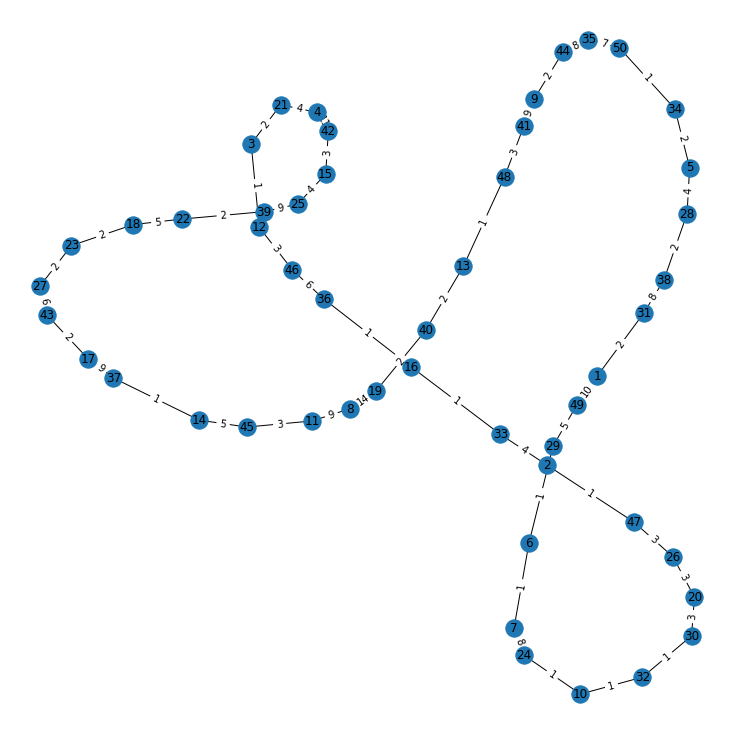

Objective Value: 200


In [14]:
solution = mdl.solve(log_output=True) # Solve the TSP problem
#print(mdl.export_to_string()) # Export the model to String
valor_objetivo = mdl.solution.get_objective_value() # Get the objective value of the final solution
x=solution.get_value_dict(x, keep_zeros=True, precision=1) # Update the 'x' dictionary with zero-valued variables
graphic(x,C,N) # Visualize the final solution
print("Objective Value:",valor_objetivo) # Print the objective value

#### Literature 
C. E. Miller, A. W. Tucker, and R. A. Zemlin. 1960. Integer Programming Formulation of Traveling Salesman Problems. J. ACM 7, 4 (Oct. 1960), 326–329. https://doi.org/10.1145/321043.321046

    
https://github.com/IBMDecisionOptimization/docplexexamples/tree/master/examples/mp/callbacks
    
